<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<H4 align='center'> Integrantes: Pablo Aguirre, Rol: 201473555-3; Jorge Aliste, Rol: 201473538-3 </H4>
<hr style="height:2px;border:none"/>

## Pregunta 2: Un problema* Multi-label*

El objetivo de esta pregunta es crear distintos modelos que sean capaces de etiquetar imágenes extraídas de la web, evaluando distintas métricas para cada uno.
<img src="https://files.virgool.io/upload/users/12226/posts/oxo6jvmweqmr/1ios2rcvohwc.png" width="35%" style="float: center;" />

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_similarity_score, hamming_loss

import re, time
from urllib.request import urlopen
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier as Tree

from sklearn.svm import SVC as SVM #SVC is for classification
from sklearn.multiclass import OneVsRestClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


> a) Cargue los datos del *output* del modelo (*labels*), descríbalos ¿Cuántos ejemplos hay por cada clase?

In [2]:
df = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_groundtruth/Lite_GT_Train.txt", delimiter="\s", header=None, engine="python")
label_names = np.loadtxt("Concepts81.txt",dtype='object')

y = df.values
y.shape

(27807, 81)

El output cuenta con 27807 registros, cada uno con 81 clases posibles.

A continuación, se crea un bar plot con las clases y sus respectivas cantidades de ejemplos.

Text(0.5,1,'Cantidad de ejemplos por clase')

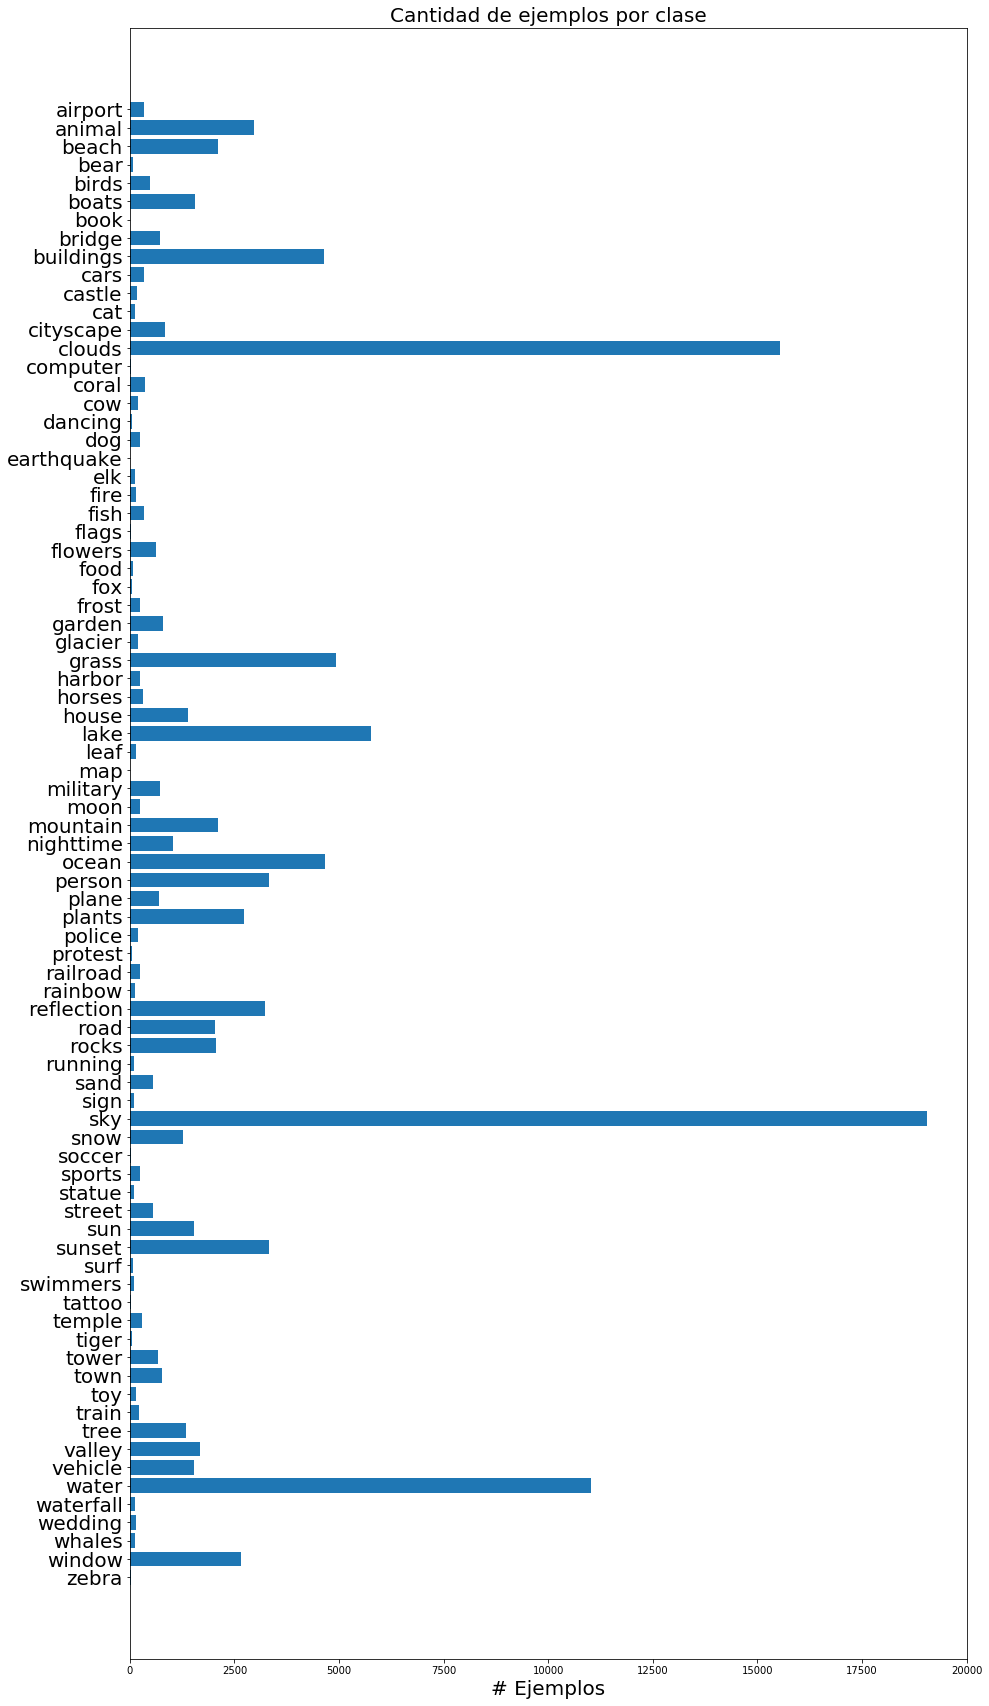

In [3]:
index = np.arange(len(label_names))
listaCantidadesEjemplos = [0]*len(label_names)

for i in index:
    listaCantidadesEjemplos[i] = df[i].sum()

fig, ax = plt.subplots(figsize=(15,30))

y_pos = np.arange(len(label_names))

ax.barh(y_pos, listaCantidadesEjemplos)
ax.set_yticks(y_pos)
ax.set_yticklabels(label_names, fontsize=20)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# Ejemplos', fontsize=20)
ax.set_title('Cantidad de ejemplos por clase', fontsize=20)

Como se puede ver, los datos no están distribuidos homogéneamente entre las clases. Las clases con mayor cantidad de ejemplos son: clouds, sky, water.

> b) Visualice el tema de que un dato  (imagen en este caso) puede tener múltiples etiquetas. Comente sobre la definición del problema *multi-label* y cómo aplica en este caso.

Etiquetas de la imagen : ['clouds' 'lake' 'sun' 'sunset' 'water']


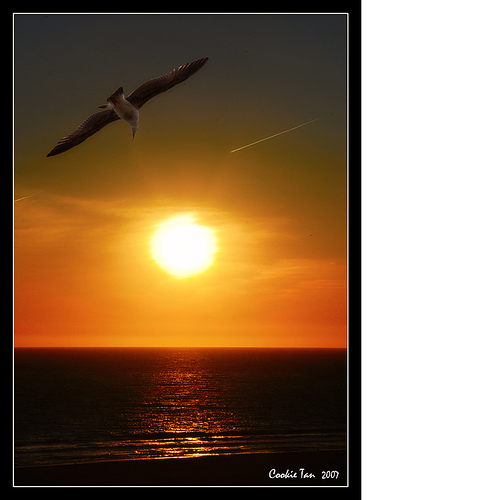

In [4]:
#label_names = np.loadtxt("Concepts81.txt",dtype='object')
arch = open("NUS-WIDE-urls.txt",'r') #lectura para mapeo de link a url

regex = re.compile("\s+")
image2url = {}

for line in arch.readlines():
    aux = regex.split(line.strip())
    image = aux[0].split("Flickr\\")[-1]
    url_m = aux[3]
    image2url[image] = url_m
arch.close()

arch = open("NUS-WIDE-Lite/image list/Train_imageOutPutFileList.txt",'r')
data_urls = [image2url[line.strip()] for line in arch.readlines()]
arch.close()

"""Visualizacion"""
s = np.random.randint(0,len(data_urls)) #mostrar para una imagen random
category_sample = np.where(y[s]==1)[0] 
print("Etiquetas de la imagen :",label_names[category_sample])
im = Image.open(urlopen(data_urls[s]))
im

Un problema multi-label es aquel en el que un registro, en este caso una imagen, puede contener mas de una clase por lo que no se trata de elegir entre una clase u otra.

> c) Comente sobre la **representación** que posee la salida de los modelos (*labels*) ¿En qué dominio habita? ¿Tiene restricciones?

La representación de las salidas para cada ejemplo es un arreglo compuesto por 0 y 1 donde el i-esimo elemento determina si la clase i está presente en el registro o no.

In [5]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

Al un problema de clasificación multi-label no existen restricciones respecto a la cantidad de clases que puede tener un registro. El dominio es ${\rm I\!R}^{81}$.

> d) Decida sobre una **representación**, en este caso descriptores, para la entrada a los modelos (*input*), puede utilizar la mezcla entre distintos descriptores, comente sobre la elección y qué representa.

La representación a elegida son los momentos de color ya que a diferencia de los histogramas de color, dividen la imagen en sectores por lo que permiten una mayor precisión al momento de clasificar.

In [6]:
#file = "Normalized_CH_Lite_Train.dat" or "Normalized_CM55_Lite_Train.dat"
#        Histograma de color           ||  momentos de color
file = "Normalized_CM55_Lite_Train.dat"
descriptors = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_features/"+file,delimiter="\s",header=None, engine ="python").values
descriptors.shape

(27807, 225)

In [7]:
descriptors[0]

array([ 0.177545, -0.084588, -0.300361, -0.119638, -0.113919,  0.159027,
       -0.143603, -0.161493, -0.135176,  0.246798, -0.258361, -0.119362,
       -0.047804, -0.062693,  0.084641, -0.103801, -0.132584,  0.227475,
        0.199286, -0.12399 , -0.166269,  0.20127 , -0.016571, -0.184839,
        0.098759, -0.075149, -0.108321,  0.077775,  0.001084, -0.257213,
        0.093128,  0.173786, -0.273731, -0.072936,  0.176965, -0.359859,
       -0.085163,  0.075707, -0.243995, -0.112819,  0.242304,  0.384603,
       -0.315928,  0.291974, -0.626111, -0.232356,  0.513898, -0.46385 ,
        0.036089,  0.208115,  0.257833, -0.104554,  0.368657, -0.579669,
        0.242258, -0.216932, -0.124544,  0.062746,  0.000945,  0.06051 ,
       -0.011163, -0.106217,  0.185759,  0.296887, -0.366409, -0.070723,
        0.093233, -0.212304, -0.02936 , -0.001333, -0.236743, -0.034466,
       -0.161763,  0.025291, -0.305736, -0.012328, -0.01259 , -0.319833,
       -0.216131,  0.320214, -0.662919, -0.07749 , 

Se tienen 27807 registros con 225 atributos cada uno.

> e) Deje un conjunto separado para evaluar los modelos y comportar como conjunto de pruebas, además de realizar la clásica estandarización de las entradas de los modelos.

In [8]:
X_train,X_test,y_train,y_test = train_test_split(descriptors,y,test_size=0.33)

std = StandardScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

In [9]:
X_train.shape

(18630, 225)

In [10]:
X_test.shape

(9177, 225)

Se cuenta con 18630 registros para entrenamiento y 9177 registros para prueba, cada uno con 225 atributos.

> f) Se presenta una métrica para validar en el código a continuación, la cual mide la cantidad de aciertos a las *labels* que tenga un dato de manera normalizada. Defina **otra** métrica a utilizar con el propósito de validar lo mismo (el desempeño de un modelo).

In [11]:
def evaluation_metric(y_true,y_pred):
    suma = 0.
    for y,yp in zip(y_true,y_pred):
        suma += np.dot(y,yp) / np.sum(y)  #cantidad de valores iguales
    return suma/float(len(y_true))

Una métrica por utilizar es Jaccard Index. Ésta consiste en

\begin{aligned}
\frac{|T \cap P|}{|T \cup P|}
\end{aligned}

Siendo T los valores verdaderos y P las predicciones. Sklearn permite calcular esta métrica con el metodo `jaccard_similarity_score(y_true, y_pred)` [[1]](#refs). Un valor más grande indica un mejor rendimiento del modelo.

Otra métrica por utilizar es Hamming Loss, la cual se define como

\begin{aligned}
\frac{1}{|N| \cdot |L|} \mathop{\sum_{i=1}^{|N|}\sum_{j=1}^{|L|}}xor(y_{i,j},z_{i,j})
\end{aligned}

Siendo $y_{i,j}$ el valor verdadero y $z_{i,j}$ la predicción. Sklearn permite calcular esta métrica con el método `hamming_loss(y_true, y_pred)` [[2]](#refs). Es una función de pérdida por lo que el valor óptimo es $0$.

> g) Experimente en resolver el problema con un Árbol de Decisión (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender de manera sencilla a *multi-label* [[4]](#refs). Mida las métricas de desempeño definidas anteriormente sobre ambos conjuntos (entrenamiento y pruebas), comente.

In [12]:
start = time.time()
modelTree = Tree(max_depth=10,criterion="gini",splitter="random", random_state=15) 
modelTree.fit(X_train,y_train)
print("Tiempo que tarda en ejecutarse:", round(time.time()-start, 1), "segundos") 

Tiempo que tarda en ejecutarse: 2.7 segundos


In [13]:
y_pred_Tree = modelTree.predict(X_test)

print("Jaccard Index: %.2F" % (jaccard_similarity_score(y_test, y_pred_Tree)))
print("Hamming Loss: %.2F" % (hamming_loss(y_test, y_pred_Tree)))

Jaccard Index: 0.29
Hamming Loss: 0.04


> h) Experimente en resolver el problema con una Máquina de Soporte Vectorial no lineal (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender a *multi-label* a través de la técnica **OneVsRest**. Mida las métricas de desempeño al igual que para el Árbol de Decisión, comente y compare sobre las métricas y los tiempos de ejecución.

In [14]:
modelSVC= SVM()
modelSVC.set_params(C=0.1,kernel='rbf', random_state=15, max_iter = 200)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=200, probability=False, random_state=15, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
start = time.time()
meta_modelSVC = OneVsRestClassifier(modelSVC, n_jobs =-1)
meta_modelSVC.fit(X_train,y_train)
print("Tiempo que tarda en ejecutarse:", round(time.time()-start, 1), "segundos") 

Tiempo que tarda en ejecutarse: 52.1 segundos


In [16]:
y_pred_SVC = meta_modelSVC.predict(X_test)

print("Jaccard Index: %.2F" % (jaccard_similarity_score(y_test, y_pred_SVC)))
print("Hamming Loss: %.2F" % (hamming_loss(y_test, y_pred_SVC)))

Jaccard Index: 0.11
Hamming Loss: 0.13


> i) Experimente en resolver el problema con una Red Neuronal *Feed Forward* (decida el número de capas y el número de neuronas, si desea puede utilizar las por defecto). Éste modelo se extiende a *multi-label* a través de la interfaz de *keras* seleccionando una *loss* adecuada, en este caso **binary cross entropy** ¿Por qué?

In [17]:
start = time.time()
modelSequential = Sequential()
modelSequential.add(Dense(256, input_dim=X_train.shape[1], activation="relu"))
modelSequential.add(Dense(128, activation="relu"))
modelSequential.add(Dense(y_train.shape[1], activation="sigmoid"))
modelSequential.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy")
modelSequential.fit(X_train, y_train, epochs=40, batch_size=128, verbose=0)
print("Tiempo que tarda en ejecutarse:", round(time.time()-start, 1), "segundos") 

Tiempo que tarda en ejecutarse: 46.0 segundos


Binary Cross Entropy es una activación Sigmoidal más una función de pérdida Cross-Entropy. Es independiente para cada vector componente (clase), lo que significa que la pérdida calculada para cada clase no se ve afectada por las otras clases. Por eso se usa en problemas de clasificación multi-label, donde la información de que un elemento pertenece a una clase no debería influenciar la decisión para otra clase.

> j)  Realice predicciones **probabilísticas** de su modelo ¿Las probabilidades están normalizadas? ¿Por qué? Además defina una forma para pasar de la representación de las probabilidades a la representación de *labels* categoricos definidos como en c).  
*Hint: Recuerde que el no pertenecer a ninguna *label*/etiqueta es una posibilidad!!*

Las probabilidades no se encuentran normalizadas ya que la suma de todas no necesariamente tiene que ser 1. Esto ya que es un problema de clasificación multi-label y se puede elegir más de una clase.

La transformación se realiza con la función `transform`, la cual ordena los índices de las clases de acuerdo a sus probabilidades descendientes y luego selecciona aquellas clases cuya probabilidad o confianza es mayor al $50\%$. Para cada registro se tiene una lista de ceros, durante `transform` se le agrega un 1 a la clase que tiene confianza mayor al $50\%$.

In [18]:
def transform(prob_pred):
    labels_pred = np.zeros((prob_pred.shape[0], prob_pred.shape[1]), dtype=int)
    
    for numero, elemento in enumerate(prob_pred):
        temp = np.argsort(elemento)[::-1]
        for indice in temp:
            if elemento[indice] >= 0.5:
                labels_pred[numero][indice] += 1
    return labels_pred

In [19]:
prob_pred_NN = modelSequential.predict(X_test) 
y_pred_NN = transform(prob_pred_NN)

> k) Ahora que recuperó la representación de las *labels* mida las métricas de desempeño sobre la Red Neuronal. Compare y comente.

In [20]:
print("Jaccard Index: %.2F" % (jaccard_similarity_score(y_test, y_pred_NN)))
print("Hamming Loss: %.2F" % (hamming_loss(y_test, y_pred_NN)))

Jaccard Index: 0.32
Hamming Loss: 0.04


En resumen, se obtuvieron los siguientes resultados al evaluar las métricas.

In [21]:
print("Árbol de Decisión: ")
print("    Jaccard Index: %.2F" % (jaccard_similarity_score(y_test, y_pred_Tree)))
print("    Hamming Loss: %.2F" % (hamming_loss(y_test, y_pred_Tree)))
print(" ")
print("SVC: ")
print("    Jaccard Index: %.2F" % (jaccard_similarity_score(y_test, y_pred_SVC)))
print("    Hamming Loss: %.2F" % (hamming_loss(y_test, y_pred_SVC)))
print(" ")
print("Red Neuronal Feed Forward: ")
print("    Jaccard Index: %.2F" % (jaccard_similarity_score(y_test, y_pred_NN)))
print("    Hamming Loss: %.2F" % (hamming_loss(y_test, y_pred_NN)))

Árbol de Decisión: 
    Jaccard Index: 0.29
    Hamming Loss: 0.04
 
SVC: 
    Jaccard Index: 0.11
    Hamming Loss: 0.13
 
Red Neuronal Feed Forward: 
    Jaccard Index: 0.32
    Hamming Loss: 0.04


Se puede apreciar que tanto el modelo basado en árbol de decisión como la red neuronal obtuvieron valores similares y mejores que la SVC. Variando los hiper parámetros y/o jugando con la cantidad de capas de la red neuronal se podrían obtener mejores resultados.

<a id="refs"></a>
## Referencias
[1] Sklearn: Jaccard Similarity Score https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_similarity_score.html

[2] Sklearn: Hamming Loss https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html